In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/textSummarization/')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pickle import load
cleanStories = load(open('/content/drive/MyDrive/textSummarization/cnn_dataset_cleaned.pkl', 'rb'))
print('Loaded Stories %d' % len(cleanStories))

Loaded Stories 92579


In [ ]:
# Populate stories and highlights in seperate lists(desc - description and highlights)
desc = []
highlights = []
for i in range(len(cleanStories)):
    desc.append(cleanStories[i]['story'])
    highlights.append(cleanStories[i]['highlights'])

In [ ]:
#%tensorflow_version 1.x
!pip install tensorflow==2.1.0

     |████████████████████████████████| 421.8 MB 26 kB/s 
     |████████████████████████████████| 3.8 MB 44.8 MB/s 
     |████████████████████████████████| 50 kB 5.1 MB/s 
     |████████████████████████████████| 448 kB 41.2 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=6e24872e37d172565cf3e2132f90f7c07a19824a6cefe5f7564b02662a93873b
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.7.0
    Uninstalling tensorboard-2.7.0:
      Successfully uninstalled tensorboard-2.7.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Succes

In [ ]:
import tensorflow as tf
tf.__version__

'2.1.0'

In [ ]:
import numpy as np  
import pandas as pd 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from attentionLayer import AttentionLayer

In [ ]:
#Adding start and end tokens
highlights =  list(map(lambda x:'_START_ '+ ' '.join(x) + ' _END_',highlights))

In [ ]:
highlights[0]

'_START_ syrian official obama climbed to the top of the tree doesnt know how to get down obama sends a letter to the heads of the house and senate obama to seek congressional approval on military action against syria aim is to determine whether cw were used not by whom says un spokesman _END_'

In [ ]:
nonTokDesc = desc[:]
#reverting tokenization
nonTokDesc = list(map(lambda x:' '.join(x),nonTokDesc))

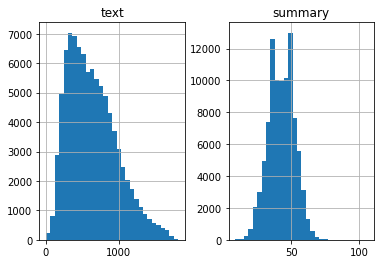

In [ ]:
import matplotlib.pyplot as plt
textWords = []
summaryWords = []

# populate the lists with sentence lengths
for i in nonTokDesc:
      textWords.append(len(i.split()))

for i in highlights:
      summaryWords.append(len(i.split()))

df = pd.DataFrame({'text':textWords, 'summary':summaryWords})
df.hist(bins = 30)
plt.show()

In [ ]:
#Lets set our max text and highlights size for padding and further reference
max_len_text= 350 
max_len_summary= 10

In [ ]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(nonTokDesc,highlights,test_size=0.1,random_state=0)

In [ ]:
# Tokenizer for desc data
desc_tokenizer = Tokenizer()
desc_tokenizer.fit_on_texts(list(x_tr))

# Text to integers
x_tr    =   desc_tokenizer.texts_to_sequences(x_tr) 
x_val   =   desc_tokenizer.texts_to_sequences(x_val)

# Padding 
x_tr    =   pad_sequences(x_tr,  maxlen=max_len_text, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=max_len_text, padding='post')

x_voc_size   =  len(desc_tokenizer.word_index) +1

In [ ]:
# Tokenizer for highlights data
hig_tokenizer = Tokenizer()
hig_tokenizer.fit_on_texts(list(y_tr))

# Text to integers
y_tr    =   hig_tokenizer.texts_to_sequences(y_tr) 
y_val   =   hig_tokenizer.texts_to_sequences(y_val) 

# Padding
y_tr    =   pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_len_summary, padding='post')
y_voc_size  =  len(hig_tokenizer.word_index) +1

In [ ]:
pip install numpy==1.19.2

     |████████████████████████████████| 14.5 MB 5.0 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-probability 0.15.0 requires gast>=0.3.2, but you have gast 0.2.2 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
from attentionLayer import AttentionLayer
from tensorflow.keras import backend as K

In [ ]:



K.clear_session() 
latent_dim = 500
#latent_dim = int(2/3 * (x_voc_size * 26)) cant use because of resourceExhaustedError

# Encoder 
encoder_inputs = Input(shape=(max_len_text,)) 
enc_emb = Embedding(x_voc_size, latent_dim,trainable=True)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3 = LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Decoder 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(y_voc_size, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 350)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 350, 500)     152135500   input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 350, 500), ( 2002000     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy') #PLSA/LDA datamining,topic mining

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [ ]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=1,batch_size=50, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Train on 83321 samples, validate on 9258 samples
83321/83321 [==============================] - 2750s 33ms/sample - loss: 6.1499 - val_loss: 6.0695


In [ ]:
# save as JSON
from tensorflow.keras.models import load_model

In [ ]:
model.save('/content/drive/MyDrive/textSummarization/EnDeAt_1.h5')  # creates a HDF5 file 'my_model.h5'
#del model  # deletes the existing model

    # returns a compiled model
    # identical to the previous one
#model = load_model('my_model.h5')
#json_string = model.to_json()

In [ ]:
#Since we are using tensorflow version below 2.5 here we have to downgrade h5 to make it compatible 
!pip install 'h5py==2.10.0'

     |████████████████████████████████| 2.9 MB 5.2 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


In [ ]:
model = load_model('/content/drive/MyDrive/textSummarization/EnDeAt_1.h5',custom_objects={"AttentionLayer": AttentionLayer})

In [ ]:
json_string

'{"class_name": "Model", "config": {"name": "model", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 350], "dtype": "float32", "sparse": false, "ragged": false, "name": "input_1"}, "name": "input_1", "inbound_nodes": []}, {"class_name": "Embedding", "config": {"name": "embedding", "trainable": true, "batch_input_shape": [null, null], "dtype": "float32", "input_dim": 304271, "output_dim": 500, "embeddings_initializer": {"class_name": "RandomUniform", "config": {"minval": -0.05, "maxval": 0.05, "seed": null}}, "embeddings_regularizer": null, "activity_regularizer": null, "embeddings_constraint": null, "mask_zero": false, "input_length": null}, "name": "embedding", "inbound_nodes": [[["input_1", 0, 0, {}]]]}, {"class_name": "LSTM", "config": {"name": "lstm", "trainable": true, "dtype": "float32", "return_sequences": true, "return_state": true, "go_backwards": false, "stateful": false, "unroll": false, "time_major": false, "units": 500, "activation": "tanh", 

In [ ]:
reverse_target_word_index=hig_tokenizer.index_word 
reverse_source_word_index=desc_tokenizer.index_word 
target_word_index=hig_tokenizer.word_index

In [ ]:
# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

NameError: ignored

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
x_val[0]

array([ 1415,  8021,     1,    56,  1168,    35,   863, 12949,     2,
         942,    11,  1555,  3763,  1726,  6421,     4,    67,   242,
           7,    60,    23,  6898,     2,     5,   671,  1927,  3598,
         125,   154,  7251,     4,   967,     1, 22372,  2595, 14984,
          10, 14984,    10,    18,   338,  9902,    14,    31,   248,
         347,  6491,     4,    67,  1039,    97,   325,     1,   279,
           4,     7,   493,     2,     1,   823,  8335,     3,     1,
       71376, 56386,    14,   892, 13232,  1039,     6,  7499,  3471,
           4, 87040,  1867,  1890, 15252,    39,    64,     3,   113,
        2260,  8021,   106,   320,   406,  2260,    62, 13246,    64,
           3,   113,  8021,    21,  4188,   613,     4,    78,    28,
        1347,     1,   745,  2692,    16,    54,    37,    52,   342,
           5,   399, 82887,    64,    21,     8,  8369,     8, 77460,
          64,    21,   932,     8,   613,     4,    61,    92,    35,
         126,   772,

In [ ]:
def valPredict(i):
  print("Review:",seq2text(x_val[i]))
  print("Original summary:",seq2summary(y_val[i]))
  print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_len_text)))
  print("\n")

In [ ]:
valPredict(24)

TypeError: ignored

In [ ]:
x_val[24]

array([ 3962,  5529,   152,  3739, 13578, 41216,   794,    97,     5,
         549,   209,    24,  1335,   892,     3,  5347,     5,  3012,
         426,     2,  4744,   554,     4, 11371,   470,     7, 11107,
          22,     1,   624,   693,     3, 13404,  7126,     5,  1872,
        1113,     2,  1893,     5,  3719, 11371,   929,    53,    12,
        1138,    48,     1,  6533,  1206,  1630,     5,  1360,   490,
         141,     3,     5,  1226,     2,     5,  6740,    24,    18,
        1079,   261,     8,    42,    65,    97,  3495,     5,  3012,
           1,   174,    12, 13561,     8,   751,   799,   865,   459,
        1970,   830,    34,   453,     8,   487,     7,  5529,  1801,
           5,  2131,   131,    14,  4952,     6,   624,    47,    30,
         517, 13404,   152,  3739,     8,  3245,     3,  1552,  1116,
        1077,     5,  3719, 11371,   929,    12,   304,    48, 13578,
       41216,   572,   332,   405,     9, 17706,  1455,  1206,  1630,
           5,   490,